Импортируем нужные библиотеки.

In [1]:
import torch
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

from torch.nn import CTCLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchmetrics import CharErrorRate
from ctc_decoder import beam_search

from dataset import CaptchaDataset
from models import Net

Далее инициализируем список токенов буквами английского алфавита и арабскими цифрами + blank (пустой) токен. Будем предполагать, что только они могут встречаться в капчах.  
Также сделаем словари для перевода токена в индекс и наоборот.

In [2]:
ALPHABET = "a b c d e f g h i j k l m n o p q r s t u v w x y z"
DIGITS = "1 2 3 4 5 6 7 8 9 0"

tokens = [".", *(ALPHABET.split(" ")), *(DIGITS.split(" "))]
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

Далее создадим даталоудеры для тренировочного и тестового наборов.  
Датасет из себя представляем набор пар: картинка (в RGB) и набор из пяти токенов (буква или цифра).  
В качестве препоцессинга используем нормализацию изображений со значениями mean и std из ImageNet, перевод картинки в тензор. Токены переведем в индексы, а их - в тензор.

In [3]:
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGE_MEAN, IMAGE_STD)
])
target_transform = transforms.Compose([
    lambda target_str: [token_to_idx[ch] for ch in target_str],
    torch.Tensor
])

trainset = CaptchaDataset(
    is_train=True,
    transform=transform,
    target_transform=target_transform
)
testset = CaptchaDataset(
    is_train=False,
    transform=transform,
    target_transform=target_transform
)

batch_size = 64
current_cpu_count = multiprocessing.cpu_count()
trainloader = DataLoader(trainset, batch_size=batch_size,
                         shuffle=True, num_workers=current_cpu_count)
testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=current_cpu_count)

Тут просто визуализация данных.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


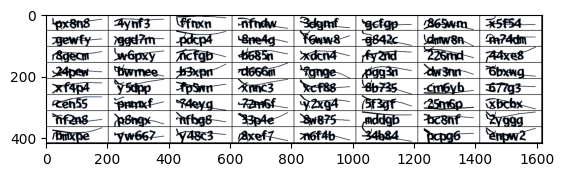

['px8n8', '4ynf3', 'ffnxn', 'nfndw', '3dgmf', 'gcfgp', '865wm', 'x5f54', 'gewfy', 'ggd7m', 'pdcp4', '8ne4g', 'f6ww8', 'g842c', 'dmw8n', 'm74dm', '8gecm', 'w6pxy', 'ncfgb', 'b685n', 'xdcn4', 'fy2nd', '226md', '44xe8', '24pew', 'bwmee', 'b3xpn', 'd666m', '7gnge', 'pgg3n', 'dw3nn', '6bxwg', 'xf4p4', 'y5dpp', 'fp5wn', 'xnnc3', 'xcf88', '8b735', 'cm6yb', '677g3', 'cen55', 'pnmxf', '74eyg', '72m6f', 'y2xg4', '5f3gf', '25m6p', 'xbcbx', 'nf2n8', 'p8ngx', 'nfbg8', '33p4e', '8w875', 'mddgb', 'bc8nf', '2yggg', 'bmxpe', 'yw667', 'y48c3', '8xef7', 'n6f4b', '34b84', 'pcpg6', 'enpw2']


In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))

letters_labels = []
for label in labels:
    letters_labels.append("".join([idx_to_token[idx.item()] for idx in label]))
    
print(letters_labels)

Надеюсь, у вас есть cuda :)

In [5]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

Создадим инстанс класса нашей сети. Архитектуру можно глянуть в файлике models.py.  
В целом все стандартно: CNN, LSTM, FC. Немного reshape и permute, чтобы подружить свертку и рекуррентку.

In [6]:
net = Net(len(tokens)).to(device)

Рутина обучения, тут все тоже стандартно. CTCLoss считается ровно как в [примере из доки](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html).

In [7]:
def train_model(net, criterion, optimizer, trainloader, num_epochs=5):
    loss_history = []
    for epoch in range(num_epochs):
        for _, data in enumerate(trainloader, 0):
            inputs, labels = data
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            pred = net(inputs.to(device))
            pred = pred.permute(1, 0, 2)
            
            input_lengths = torch.full(size=(inputs.shape[0],), fill_value=pred.shape[0], dtype=torch.long)
            target_lengths = torch.full(size=(inputs.shape[0],), fill_value=labels.shape[1], dtype=torch.long)
            
            loss = criterion(pred.log_softmax(-1), labels, input_lengths, target_lengths)
            loss_history.append(loss.item())
            
            loss.backward()
            
            optimizer.step()
            
            optimizer.zero_grad()

        if epoch % 10 == 9:
            print(f"Epoch: {epoch + 1}, current_loss: {loss.item()}, mean loss through the history: {sum(loss_history) / len(loss_history)}")

    print('Finished Training')
    
    return net

Отпимизатор - Адам. Лосс - CTCLoss.

In [8]:
optimizer = Adam(net.parameters())
criterion = CTCLoss()

Треним много эпох, я рил надеюсь, что у вас есть gpu :)  
Но, если нету, то лучше использовать заранее подготовленную мною модель. В этом случае просто раскомментируйте код ниже.

In [9]:
PATH_TO_MODEL = "net.pkl"

# net.load_state_dict(torch.load(PATH_TO_MODEL))
# net.to(device)

Ниже train loop. Его нужно закомментировать, если хотите использовать заранее подготовленную модель.

In [10]:
net = train_model(net, criterion, optimizer, trainloader, 200)

Epoch: 10, current_loss: 0.1641921103000641, mean loss through the history: 1.2564903961064724
Epoch: 20, current_loss: 0.05144334211945534, mean loss through the history: 0.6471764483309995
Epoch: 30, current_loss: 0.055066946893930435, mean loss through the history: 0.4463175573457892
Epoch: 40, current_loss: 0.0019163481192663312, mean loss through the history: 0.33969769948475564
Epoch: 50, current_loss: 0.01031518541276455, mean loss through the history: 0.2729542984478534
Epoch: 60, current_loss: 0.006843600422143936, mean loss through the history: 0.22826322150007727
Epoch: 70, current_loss: 0.0006613633595407009, mean loss through the history: 0.1960719504966759
Epoch: 80, current_loss: 0.0004335619742050767, mean loss through the history: 0.17164695015489997
Epoch: 90, current_loss: 0.00019407778745517135, mean loss through the history: 0.1526068637835466
Epoch: 100, current_loss: 0.00022446244838647544, mean loss through the history: 0.13736656232879166
Epoch: 110, current_lo

Ну и наконец CharErrorRate.

In [11]:
labels_preds = []
labels_reals = []

char_error_rate = CharErrorRate()
char_error_rate_history = []
with torch.no_grad():
    for inputs, labels in testloader:
        labels = labels.to(device)
        
        pred_probs = net(inputs.to(device)).softmax(-1)
        
        labels_pred = []
        for batch_item in pred_probs:
            letters_pred = []
            for probs in batch_item.cpu():
                letters_pred.append([*[item.item() for item in probs[1:]], probs[:1].item()])
            tokens_pred = beam_search(np.array([np.array(xi) for xi in letters_pred]), tokens[1:])
            labels_pred.append(tokens_pred)
            labels_preds.append(tokens_pred)
        
        labels_real = []
        for label in labels:
            tokens_real = "".join([idx_to_token[item.item()] for item in label])
            labels_real.append(tokens_real)
            labels_reals.append(tokens_real)
            
        
        char_error_rate_history.append(char_error_rate(labels_real, labels_pred).item())

print(f"Char Error Rates on test data: {char_error_rate_history}")
print(f"Mean Char Error Rate on test data: {sum(char_error_rate_history) / len(char_error_rate_history)}")

Char Error Rates on test data: [0.04193548485636711, 0.04207119718194008, 0.02555910497903824, 0.03896103799343109]
Mean Char Error Rate on test data: 0.03713170625269413


В среднем ошибаемся в <5% случаях, что считаю вполне неплохим результатом.

Сохраним наш результат.

In [12]:
torch.save(net.state_dict(), PATH_TO_MODEL)

Теперь посмотрим на наши предсказания и попытаемся понять, какие у модели проблемы.

In [13]:
for i, _ in enumerate(labels_reals):
    real = labels_reals[i]
    pred = labels_preds[i]
    print(f"{real} : {pred}")

2g783 : 2g783
5mgn4 : 5mgn4
5nnff : 5nf
57gnx : 57gnx
58b5m : 58b5m
b5dn4 : b5dn4
eppg3 : epg3
65m85 : 65m85
byfgn : byfgn
2n73f : 2n73f
8n34n : 8n34n
ppwyd : ppwyd
xc68n : xc68n
7nnnx : 7nx
5mcy7 : 5mcy7
x347n : x347n
pwmbn : pwmbn
ng2gw : ng2gw
y866y : y866y
467d5 : 467d5
d7c5x : d7c5x
pgmn2 : pgmn2
xe8xm : xe8xm
n4b4m : n4b4m
gecmf : gecmf
ffd6p : fd6p
6c3n6 : 6c3n6
n464c : n464c
675p3 : 675p3
neecd : necd
wyc25 : wyc25
gw468 : gw468
x775w : x75w
6e2dg : 6e2dg
243mm : 243mm
f8f8g : f8f8g
bw44w : bw4w
ddnpf : ddnpf
c8fxy : c8fxy
nb267 : nb267
f5e5e : f5e5e
bnc2f : bnc2f
33n73 : 33n73
33b22 : 33b2
6n5fd : 6n5fd
c4mcm : c4mcm
efgx5 : efgx5
fg38b : fg38b
pmg55 : nmg55
6e6pn : 6e6pnf
mc35n : mc35n
ccn2x : ccn2x
556wd : 556wd
5g5e5 : 5g5e5
2nbcx : 2nbcx
dd5w5 : dd5w5
myf82 : myf82
eng53 : eng53
n8pfe : n8pfe
gbxyy : gbxy
exycn : exycn
474ff : 474ff
gc2wd : gc2wd
gd8fb : gd8fb
fc2ff : fc2f
wecfd : wecfd
2wc38 : 2wc38
m3wfw : m3wfw
ec6pm : ec6pm
e3ndn : e3ndn
d6fcn : d6fcn
47m2b : 47m2b
bn5

Невооруженным глазом видно, что модель чаще ошибается на картинках, где есть повторы токенов.  
* 5*nn*ff : 5*n*ff
* m*44*8b : m*4*8b
* 3*nn*pw : 3*n*pw
* pyb*ee* : pyb*e*  

К тому же этих самых предсказанных токенов всегда меньше, чем нужно (<5).  
Это, в первую очередь, связано с самим CTCLoss, т к он больше предназначен для распознавания последовательностей разной длинны. То есть мы теряем приемущество в виде гарантии того, что у нас в капче символов ровно 5. Но с другой стороны, никто нигде этого не говорил :)  

Другое предположение строится на том, что таких капч (где повторяюся токены) в датасете немного. Поэтому можно было бы попробовать аугментировать некоторые из этих капч, дабы модель лучше научилась распознавать такие случае.  

Ну и плюс ко всему сами данные кривые. С разметкой нужно бы еще поработать, поэтому идеального результата тут в любом случае не будет :)